## Imports

In [5]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV  # Importar GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

## Extracting the Path

In [7]:
root_path = "C:\\Users\\natyo\\RO11\\archive"

train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")

emotion_list = os.listdir(train_path)
print("Number of emotions: {}".format(len(emotion_list)))
print(emotion_list)

# Map emotions to numerical labels
emotion_mapping = {emotion: idx for idx, emotion in enumerate(emotion_list)}

Number of emotions: 7
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Features Extaction

## LBP

The **Local Binary Pattern (LBP)** is a technique that converts an image into a set of binary patterns based on the relationship between a pixel and its neighbors. The basic idea is to compare each pixel with the ones around it (neighborhood) and assign a binary value (0 or 1) depending on whether the neighboring pixels are larger or smaller than the center.

1. For each pixel, the surrounding pixels (neighborhood) are evaluated.
2. A binary value is assigned depending on whether the neighboring pixels are larger or smaller than the value of the center pixel.
3. These binary values ​​form a binary number that is converted to a decimal value.
4. A histogram of these values ​​is generated, which represents the characteristics of the image.

**Limitations**:
- It is not suitable for images with many details or complex structures, since it is only based on the relationship between neighboring pixels.

In [3]:
radius = 2  
n_points = 8 * radius  

def extract_lbp_features(image):
    lbp = local_binary_pattern(image, n_points, radius, method="ror")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7) 
    return hist


def load_data_and_extract_features_lbt(data_path):
    X = []
    y = []
    for emotion in os.listdir(data_path):
        emotion_folder = os.path.join(data_path, emotion)
        for img_file in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            features = extract_lbp_features(img)
            X.append(features)
            y.append(emotion_mapping[emotion])
    return np.array(X), np.array(y)

X_train, y_train = load_data_and_extract_features_lbt(train_path)
X_test, y_test = load_data_and_extract_features_lbt(test_path)


## Gabor Filters

**Gabor Filters** are a family of convolution filters that act as spatial frequency detectors. They can capture textures and patterns in different directions and frequencies, making them ideal for analyzing complex textures.

1. A Gabor filter is a sine wave (frequency) modulated by a Gaussian function. Essentially, a directional filter is superimposed on top of it that responds to different orientations and frequencies.
2. Different Gabor filters are applied to an image, each with a specific orientation and frequency, detecting patterns along lines or edges in specific directions.
3. The result is a set of filtered images that highlight texture and edge features in the original image.

**Limitations**:
- Requires tuning several parameters (frequency, orientation, etc.), which can be complex.
- More computationally expensive than LBP and HOG.

In [4]:
def extract_gabor_features(image):
    gabor_filters = []
    for theta in np.arange(0, np.pi, np.pi / num_orientations):
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, psi, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        gabor_filters.append(filtered_img)
    return np.array(gabor_filters).flatten()

def load_data_and_extract_features_gabor(data_path):
    X = []
    y = []
    for emotion in os.listdir(data_path):
        emotion_folder = os.path.join(data_path, emotion)
        for img_file in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            features = extract_gabor_features(img)
            X.append(features)
            y.append(emotion_mapping[emotion])
    return np.array(X), np.array(y)

X_train, y_train = load_data_and_extract_features_gabor(train_path)
X_test, y_test = load_data_and_extract_features_gabor(test_path)

## HOG

The **Histogram of Oriented Gradients (HOG)** is a method that analyzes gradients or changes in pixel intensity in an image to detect edges and shapes. HOG is especially good at capturing the structure and geometry of an image, such as lines or contours.

1. The image is divided into small cells and in each one a histogram of the gradient directions is calculated.
2. Gradients are calculated by taking the magnitude and direction of the changes in pixel intensity.
3. These histograms are grouped into blocks that are normalized to reduce the effects of lighting.
4. The final result is a vector that combines the gradient histograms, providing a robust description of the shapes in the image.

**Limitations**:
- It consumes more computational resources compared to LBP.
- It is not as effective when textures play an important role.

In [8]:
def extract_hog_features(image):
    resized_image = cv2.resize(image, (64, 128))
    hog = cv2.HOGDescriptor()
    h = hog.compute(resized_image)
    return h.flatten()

def load_data_and_extract_features_hog(data_path):
    X = []
    y = []
    for emotion in os.listdir(data_path):
        emotion_folder = os.path.join(data_path, emotion)
        for img_file in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            features = extract_hog_features(img)
            X.append(features)
            y.append(emotion_mapping[emotion])
    return np.array(X), np.array(y)

X_train, y_train = load_data_and_extract_features_hog(train_path)
X_test, y_test = load_data_and_extract_features_hog(test_path)

# KNN

The K-Nearest Neighbors (KNN) algorithm is a supervised classifier used for classification and regression tasks. It is based on the idea of ​​finding close "neighbors" in the feature space.
- KNN does not require an explicit training process. It simply stores all the training examples with their respective labels.
- For the new instance, KNN calculates the distance between this point and all the points in the training data.
- KNN then selects the k closest points to the new instance.
- A "vote" is taken. That is, KNN counts how many of those neighbors belong to each class and assigns the new instance to the class with the majority of votes.

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.502089718584564


## Confusion matrix

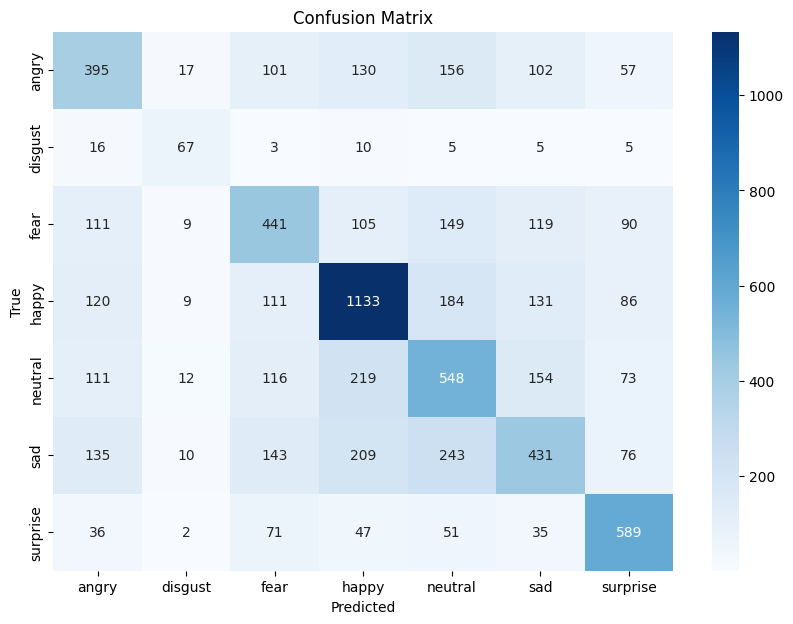

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_mapping.keys()), 
            yticklabels=list(emotion_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Results

Tests were performed with each of the feature extraction modes, using KNN for all of them.

### LBP Results

Accuracy: 0.24965171356923935

<img src="Img1.png" alt="LBT" width="800">


### Gabor Results

Accuracy: 0.3978824185009752

<img src="Img2.png" alt="Gabor" width="600">


### HOG

Accuracy: 0.502089718584564

<img src="Img3.png" alt="HOG" width="600">



## Conclusions

It can be seen that the best result is obtained with HOG feature recognition.

The fact that it is better than other methods in classifying facial expressions can be due to its ability to capture important details of shapes and edges in images. This is important since facial expressions are strongly determined by changes in the edges and contours of the face, such as wrinkles on the forehead, lines around the eyes, changes in the shape of the mouth, etc.
In addition, HOG is robust against lighting changes. It also helps reduce the effects of small rotations, which can be present when expressions vary slightly from one angle to another.

Finally, while other methods such as LBP focus on local features (comparisons of neighboring pixels), HOG has the advantage of working at a more global level, capturing the structure of the image. This is especially useful in facial expressions, since many expressions depend on how certain parts of the face move in relation to others (e.g. the mouth and eyes).
